In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [31]:
svi_raw = pd.read_csv("SVI_2020_US_county.csv")
svi_by_state = svi_raw.groupby('ST_ABBR')['RPL_THEMES'].mean().reset_index()
svi_by_state.rename(columns={'ST_ABBR': 'State', 'RPL_THEMES': 'SVI'}, inplace=True)


In [32]:
url = "https://www.fema.gov/api/open/v2/DisasterDeclarationsSummaries.csv"
df = pd.read_csv(url, low_memory=False)

df = df[['disasterNumber', 'state', 'incidentType', 'declarationDate',
         'incidentBeginDate', 'incidentEndDate', 'designatedArea',
         'declarationType', 'fyDeclared']]

df.columns = ['DisasterNumber', 'State', 'IncidentType', 'DeclarationDate',
              'BeginDate', 'EndDate', 'County', 'DeclarationType', 'FiscalYear']

df.dropna(subset=['State', 'IncidentType', 'BeginDate'], inplace=True)


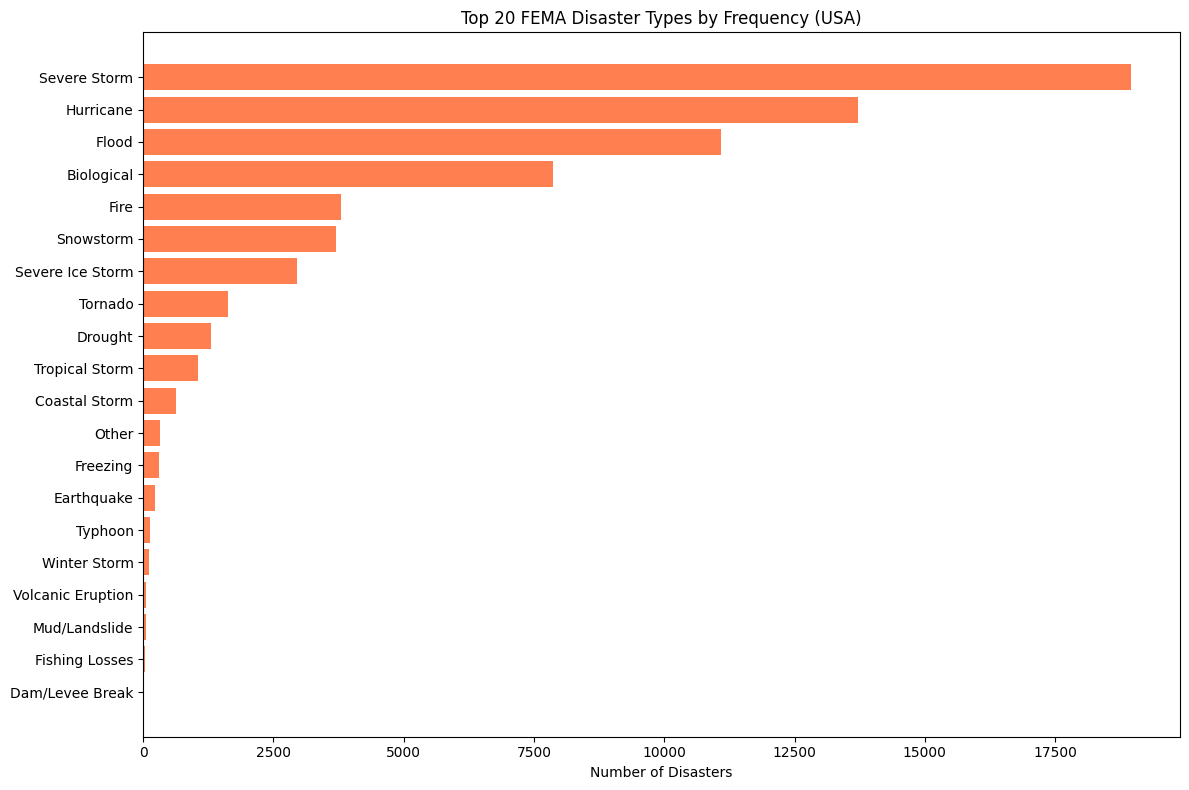

In [33]:
incident_counts = df['IncidentType'].value_counts().reset_index()
incident_counts.columns = ['IncidentType', 'Count']

plt.figure(figsize=(12, 8))
plt.barh(incident_counts.head(20).sort_values('Count')['IncidentType'],
         incident_counts.head(20).sort_values('Count')['Count'], color='coral')
plt.title('Top 20 FEMA Disaster Types by Frequency (USA)')
plt.xlabel('Number of Disasters')
plt.tight_layout()
plt.show()


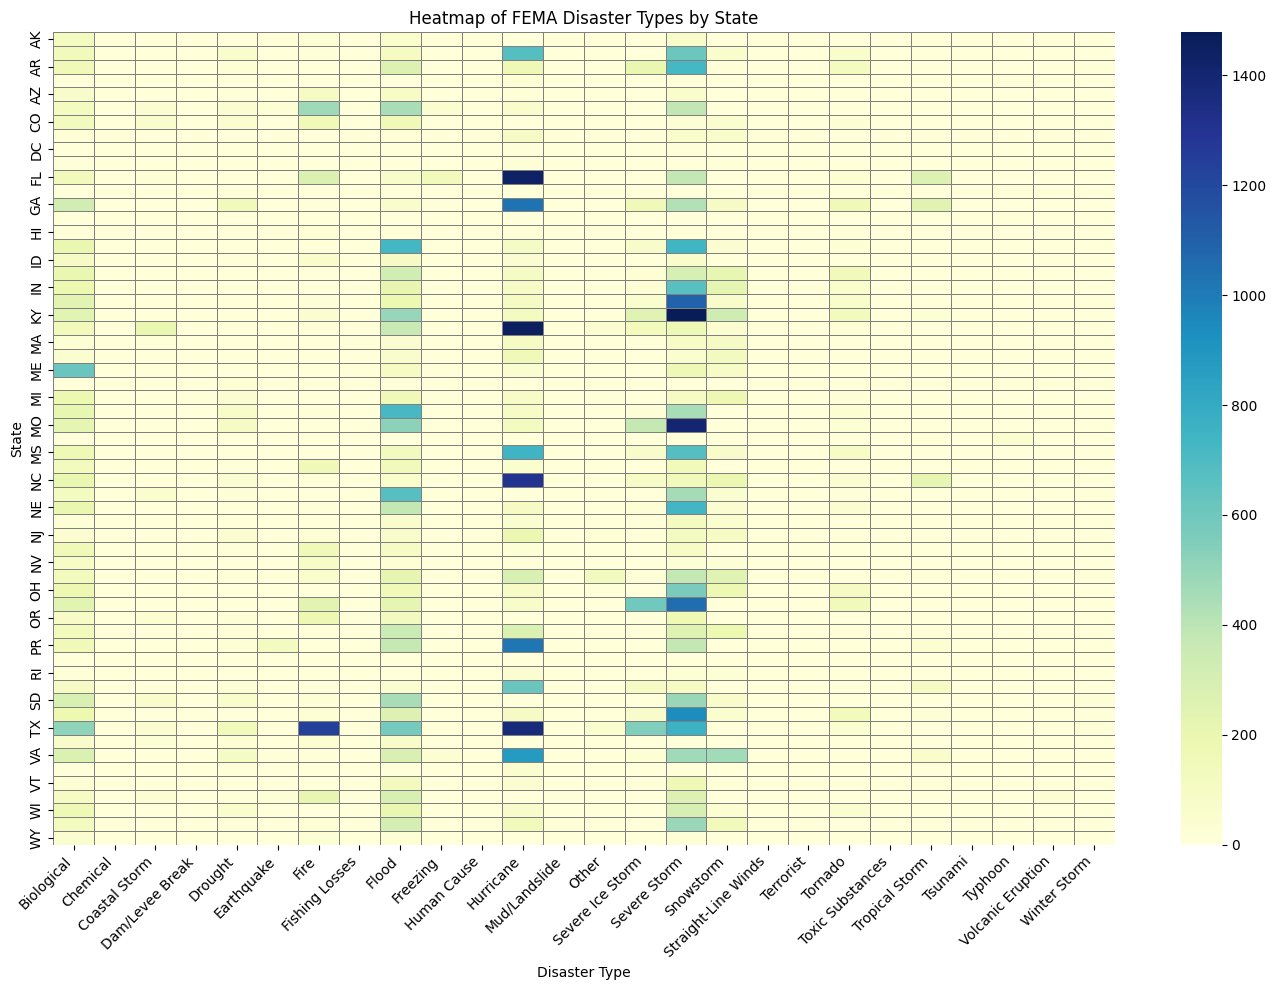

In [34]:
pivot_df = df.groupby(['State', 'IncidentType']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_df, cmap="YlGnBu", linewidths=0.5, linecolor='gray')
plt.title('Heatmap of FEMA Disaster Types by State')
plt.xlabel('Disaster Type')
plt.ylabel('State')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


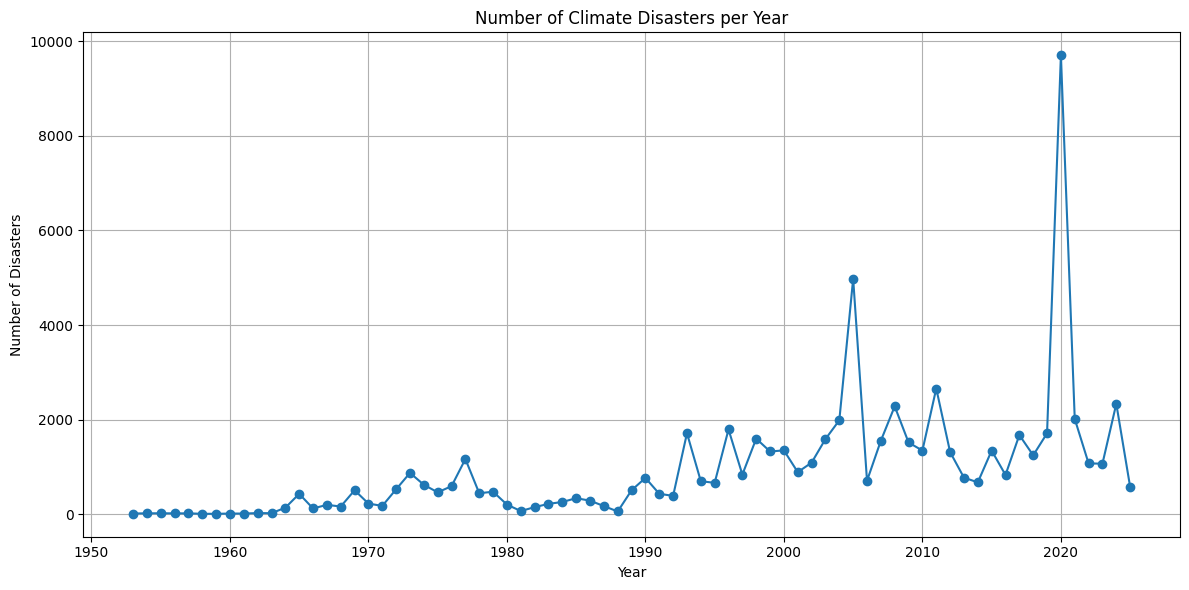

In [35]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'])
df['Year'] = df['BeginDate'].dt.year
yearly_counts = df.groupby('Year').size()

plt.figure(figsize=(12, 6))
yearly_counts.plot(marker='o', linestyle='-')
plt.title('Number of Climate Disasters per Year')
plt.xlabel('Year')
plt.ylabel('Number of Disasters')
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
# ▶️ KMeans clustering of states by disaster profile
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare pivot table: State x IncidentType
pivot_cluster_df = df.groupby(['State', 'IncidentType']).size().unstack(fill_value=0)

# Scale the data
scaler = StandardScaler()
pivot_scaled = scaler.fit_transform(pivot_cluster_df)

# Cluster into 4 groups
kmeans = KMeans(n_clusters=4, random_state=42)
pivot_cluster_df['Cluster'] = kmeans.fit_predict(pivot_scaled)

# Save results
state_clusters = pivot_cluster_df['Cluster'].reset_index()
state_clusters.head()


,State,Cluster
0,AK,3
1,AL,1
2,AR,1
3,AS,3
4,AZ,3


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [38]:
df['DeclarationDate'] = pd.to_datetime(df['DeclarationDate'], errors='coerce')
df = df.dropna(subset=['DeclarationDate', 'State'])
df['Year'] = df['DeclarationDate'].dt.year
df['is_fire'] = df['IncidentType'].str.lower().eq('fire').astype(int)
fires_per_year = df.groupby(['State', 'Year'])['is_fire'].max().reset_index()
fires_per_year.rename(columns={'State': 'State'}, inplace=True)


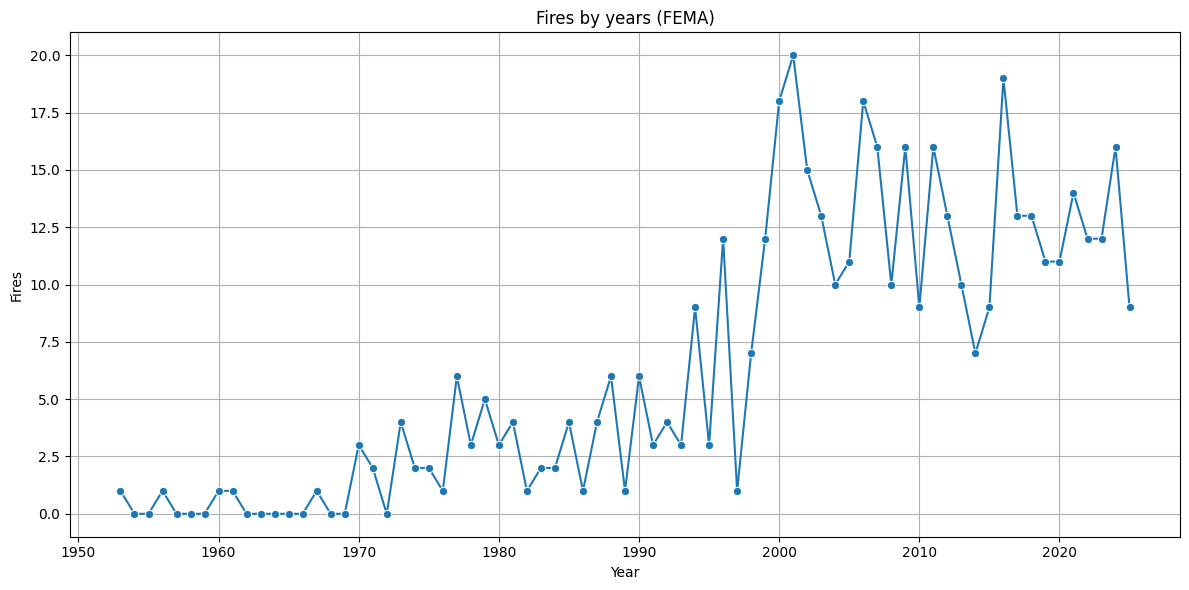

In [39]:
fires_by_year = fires_per_year.groupby('Year')['is_fire'].sum().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(x='Year', y='is_fire', data=fires_by_year, marker='o')
plt.title('Fires by years (FEMA)')
plt.xlabel('Year')
plt.ylabel('Fires')
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
svi_raw = pd.read_csv("SVI_2020_US_county.csv")
svi_by_state = svi_raw.groupby('ST_ABBR')['RPL_THEMES'].mean().reset_index()
svi_by_state.rename(columns={'ST_ABBR': 'State', 'RPL_THEMES': 'SVI'}, inplace=True)


In [41]:
fires_per_year = fires_per_year.merge(svi_by_state, on='State', how='left')
fires_per_year['SVI'] = fires_per_year['SVI'].fillna(fires_per_year['SVI'].median())


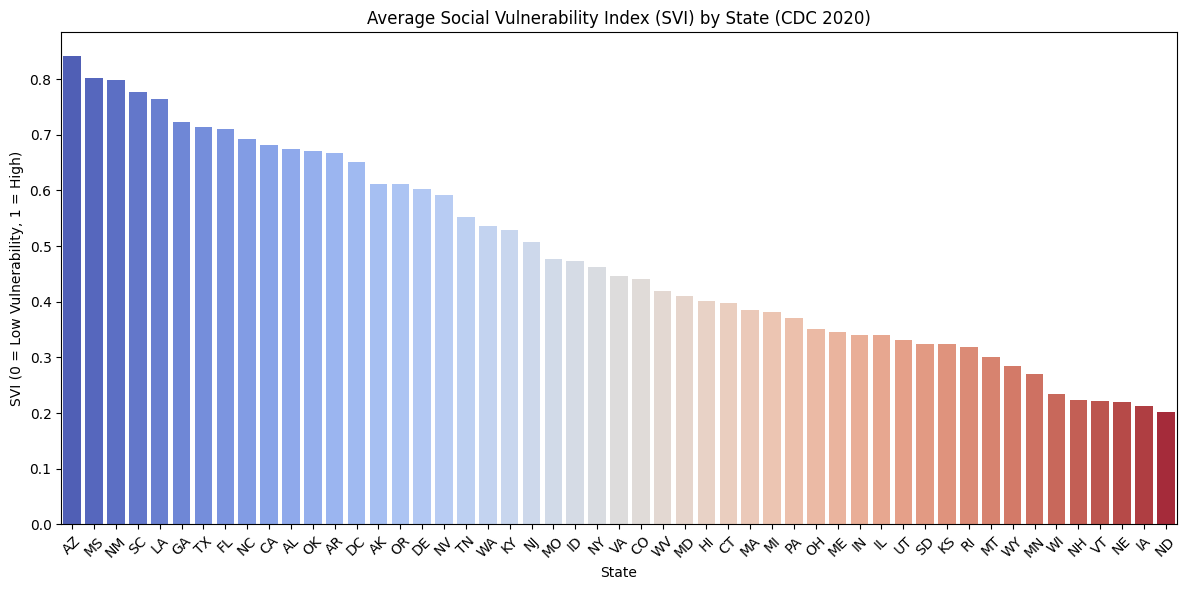

In [42]:
plt.figure(figsize=(12, 6))
sorted_svi = svi_by_state.sort_values('SVI', ascending=False)
sns.barplot(x='State', y='SVI', hue='State', data=sorted_svi, palette='coolwarm', legend=False)
plt.xticks(rotation=45)
plt.title('Average Social Vulnerability Index (SVI) by State (CDC 2020)')
plt.ylabel('SVI (0 = Low Vulnerability, 1 = High)')
plt.xlabel('State')
plt.tight_layout()
plt.show()


In [43]:
X = fires_per_year[['SVI', 'Year']]
y = fires_per_year['is_fire']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.88      0.87       425
           1       0.53      0.49      0.51       116

    accuracy                           0.80       541
   macro avg       0.70      0.69      0.69       541
weighted avg       0.79      0.80      0.79       541



In [44]:
print(drought_df.columns.tolist())


['MapDate', 'State', 'None', 'D0', 'D1', 'D2', 'D3', 'D4', 'ValidStart', 'ValidEnd', 'StatisticFormatID', 'Year', 'DroughtLevel']


In [45]:
drought_df = pd.read_csv("dm_export_20000101_20231231.csv")

drought_df['ValidStart'] = pd.to_datetime(drought_df['ValidStart'])
drought_df['Year'] = drought_df['ValidStart'].dt.year

drought_df['DroughtLevel'] = (
    drought_df['D0'] * 0 +
    drought_df['D1'] * 1 +
    drought_df['D2'] * 2 +
    drought_df['D3'] * 3 +
    drought_df['D4'] * 4
) / 100

drought_df.rename(columns={'StateAbbreviation': 'State'}, inplace=True)

state_year_drought = drought_df.groupby(['State', 'Year'])['DroughtLevel'].mean().reset_index()
state_year_drought.rename(columns={'DroughtLevel': 'AvgDroughtLevel'}, inplace=True)


In [46]:
fires_with_drought = pd.merge(fires_per_year, state_year_drought, on=['State', 'Year'], how='left')
fires_with_drought['AvgDroughtLevel'] = fires_with_drought['AvgDroughtLevel'].fillna(
    fires_with_drought['AvgDroughtLevel'].median())

X = fires_with_drought[['SVI', 'Year', 'AvgDroughtLevel']]
y = fires_with_drought['is_fire']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.93      0.90       425
           1       0.67      0.55      0.61       116

    accuracy                           0.85       541
   macro avg       0.78      0.74      0.76       541
weighted avg       0.84      0.85      0.84       541



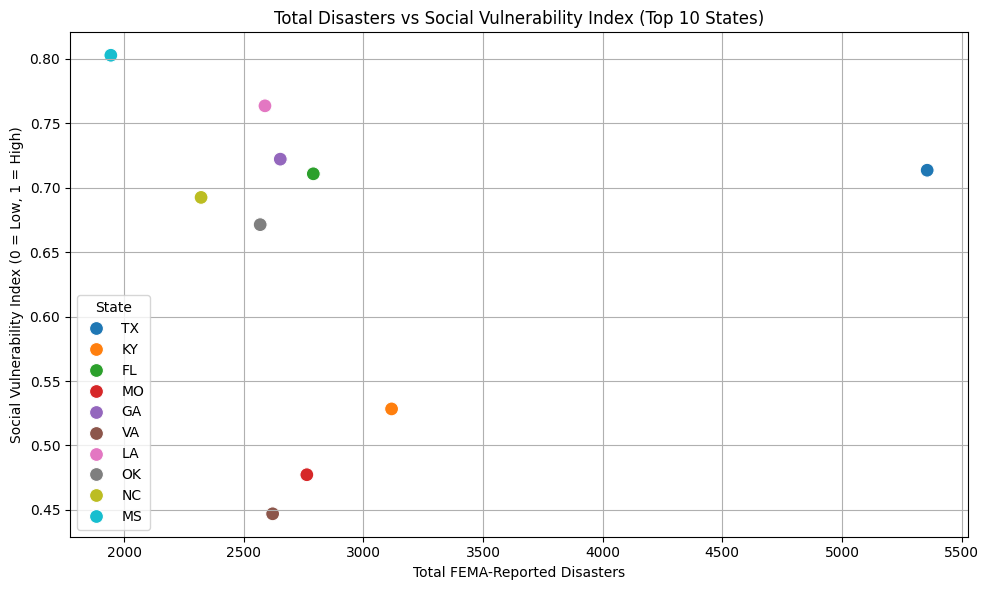

In [26]:
disaster_counts = df.groupby('State').size().reset_index(name='TotalDisasters')
disaster_counts.rename(columns={'State': 'State'}, inplace=True)

disaster_svi = disaster_counts.merge(svi_by_state, on='State', how='left').dropna()

top_states = disaster_svi.sort_values(by='TotalDisasters', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=top_states, x='TotalDisasters', y='SVI', hue='State', s=100)

plt.title('Total Disasters vs Social Vulnerability Index (Top 10 States)')
plt.xlabel('Total FEMA-Reported Disasters')
plt.ylabel('Social Vulnerability Index (0 = Low, 1 = High)')
plt.legend(title='State')
plt.grid(True)
plt.tight_layout()
plt.show()
